In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tsfresh import extract_features, extract_relevant_features
from tsfresh.feature_extraction.settings import from_columns
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters
pd.set_option("display.max_columns", 400)
%matplotlib inline
def feature_row(book):
    for i in [
            1,
            2,
    ]:
        # wap
        book[f'book_wap{i}'] = (book[f'bid_price{i}'] * book[f'ask_size{i}'] +
                                book[f'ask_price{i}'] *
                                book[f'bid_size{i}']) / (book[f'bid_size{i}'] +
                                                         book[f'ask_size{i}'])

    # mean wap
    book['book_wap_mean'] = (book['book_wap1'] + book['book_wap2']) / 2

    # wap diff
    book['book_wap_diff'] = book['book_wap1'] - book['book_wap2']

    # other orderbook features
    book['book_price_spread'] = (book['ask_price1'] - book['bid_price1']) / (
        book['ask_price1'] + book['bid_price1'])
    book['book_bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['book_ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['book_total_volume'] = book['ask_size1'] + book['ask_size2'] + book[
        'bid_size1'] + book['bid_size2']
    book['book_volume_imbalance'] = (book['ask_size1'] + book['ask_size2']) - (
        book['bid_size1'] + book['bid_size2'])
    return book
def log_return(list_stock_prices):
    """收益率
    """
    return np.log(list_stock_prices).diff()


def realized_volatility(series_log_return):
    """波动率
    """
    return np.sqrt(np.sum(series_log_return**2))

In [116]:
book0 = pd.read_parquet('../input/book-ffill/book_train.parquet/stock_id=0/8a63186613aa46f98aeaa288e982be5a.parquet')
trade0 = pd.read_parquet('../input/trade_ffill/trade_train.parquet/stock_id=0/0788f1b95ece49f58ac27c87ca6b5fa7.parquet')
df0 = book0.merge(trade0, on=['time_id', 'seconds_in_bucket'])
df0 = feature_row(df0)
df0['minute'] = df0['seconds_in_bucket'] // 60
df0['minute_volatility'] = df0.groupby(['time_id', 'minute'])['book_wap1'].transform(lambda x: realized_volatility(log_return(x)))
df0['first_half_volatility'] = df0.groupby(['time_id'])['book_wap1'].transform(lambda x: realized_volatility(log_return(x)))
df0['stock_id'] = 0
y = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
y0 = y.loc[y['stock_id']==0]
df0 = df0.merge(y0, on=['stock_id', 'time_id'])
df0

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,price,size,order_count,book_wap1,book_wap2,book_wap_mean,book_wap_diff,book_price_spread,book_bid_spread,book_ask_spread,book_total_volume,book_volume_imbalance,minute,minute_volatility,first_half_volatility,stock_id,target
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,1.002301,0,0,1.001434,1.001390,1.001412,0.000044,0.000439,0.000052,-0.000052,331,321,0,0.001057,0.004499,0,0.004136
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,1.002301,0,0,1.001448,1.001390,1.001419,0.000058,0.000439,0.000052,-0.000052,205,195,0,0.001057,0.004499,0,0.004136
2,5,2,1.001422,1.002301,1.001370,1.002353,3,100,2,100,1.002301,0,0,1.001448,1.001390,1.001419,0.000058,0.000439,0.000052,-0.000052,205,195,0,0.001057,0.004499,0,0.004136
3,5,3,1.001422,1.002301,1.001370,1.002353,3,100,2,100,1.002301,0,0,1.001448,1.001390,1.001419,0.000058,0.000439,0.000052,-0.000052,205,195,0,0.001057,0.004499,0,0.004136
4,5,4,1.001422,1.002301,1.001370,1.002353,3,100,2,100,1.002301,0,0,1.001448,1.001390,1.001419,0.000058,0.000439,0.000052,-0.000052,205,195,0,0.001057,0.004499,0,0.004136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2297995,32767,595,0.998275,0.998754,0.998179,0.998946,92,90,26,28,0.998547,0,0,0.998517,0.998549,0.998533,-0.000031,0.000240,0.000096,-0.000192,236,0,19,0.000001,0.001901,0,0.001084
2297996,32767,596,0.998275,0.998754,0.998179,0.998946,92,90,26,28,0.998547,0,0,0.998517,0.998549,0.998533,-0.000031,0.000240,0.000096,-0.000192,236,0,19,0.000001,0.001901,0,0.001084
2297997,32767,597,0.998275,0.998754,0.998179,0.998946,92,90,26,28,0.998547,0,0,0.998517,0.998549,0.998533,-0.000031,0.000240,0.000096,-0.000192,236,0,19,0.000001,0.001901,0,0.001084
2297998,32767,598,0.998275,0.998754,0.998179,0.998946,92,90,26,28,0.998547,0,0,0.998517,0.998549,0.998533,-0.000031,0.000240,0.000096,-0.000192,236,0,19,0.000001,0.001901,0,0.001084


,first_half_volatility,target,difference
time_id,,,
5,0.004499,0.004136,0.000364
11,0.001204,0.001445,-0.000240
16,0.002369,0.002168,0.000200
31,0.002574,0.002195,0.000379
62,0.001894,0.001747,0.000147
...,...,...,...
32751,0.002579,0.002611,-0.000032
32753,0.002206,0.001190,0.001016
32758,0.002913,0.004264,-0.001350


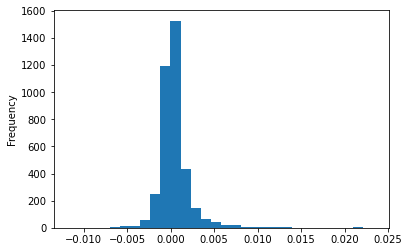

In [117]:
compare = df0.loc[:, ['time_id', 'first_half_volatility', 'target']].drop_duplicates().reset_index(drop=True)
compare['difference'] = compare['first_half_volatility'] - compare['target']
compare['difference'].plot.hist(bins=30)
compare = compare.set_index('time_id')
compare

In [118]:
df0_ = df0.loc[df0['time_id']==16, ['minute', 'minute_volatility']].drop_duplicates(subset=['minute']).reset_index(drop=True)
df0_

,minute,minute_volatility
0,0,0.000440
1,1,0.000704
2,2,0.000194
3,3,0.000134
4,4,0.000538
5,5,0.000893
6,6,0.000380
7,7,0.000385
8,8,0.000040
9,9,0.001308


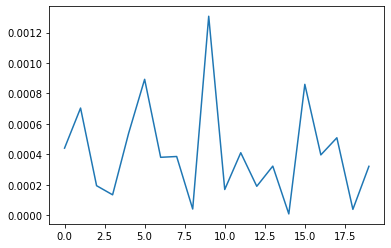

In [119]:
plt.plot(df0_['minute_volatility'])
plt.show()

In [120]:
compare

,first_half_volatility,target,difference
time_id,,,
5,0.004499,0.004136,0.000364
11,0.001204,0.001445,-0.000240
16,0.002369,0.002168,0.000200
31,0.002574,0.002195,0.000379
62,0.001894,0.001747,0.000147
...,...,...,...
32751,0.002579,0.002611,-0.000032
32753,0.002206,0.001190,0.001016
32758,0.002913,0.004264,-0.001350


In [121]:
labels = compare['difference']
labels

time_id
5        0.000364
11      -0.000240
16       0.000200
31       0.000379
62       0.000147
           ...   
32751   -0.000032
32753    0.001016
32758   -0.001350
32763   -0.001306
32767    0.000818
Name: difference, Length: 3830, dtype: float64

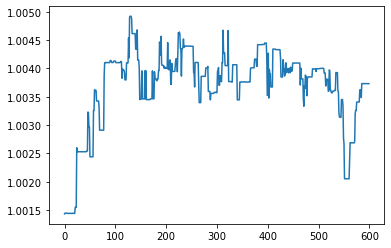

In [122]:
plt.plot( df0.loc[:599, 'book_wap1'])
plt.show()

In [123]:
feature_df = df0.loc[:, ['time_id', 'minute', 'minute_volatility']].drop_duplicates(subset=['minute', 'time_id']).reset_index(drop=True)
feature_df

,time_id,minute,minute_volatility
0,5,0,0.001057
1,5,1,0.001266
2,5,2,0.001090
3,5,3,0.000366
4,5,4,0.001339
...,...,...,...
76595,32767,15,0.000454
76596,32767,16,0.000301
76597,32767,17,0.000473
76598,32767,18,0.000952


In [124]:
# extracted_features = extract_relevant_features(df0[['book_wap1', 'time_id', 'seconds_in_bucket']], y0, column_id="time_id", column_sort="seconds_in_bucket", default_fc_parameters=EfficientFCParameters())
# extracted_features = extract_features(df0[['book_wap1', 'time_id', 'seconds_in_bucket']], column_id="time_id", column_sort="seconds_in_bucket", default_fc_parameters=list(kind_to_fc_parameters.values())[0])
extracted_features = extract_relevant_features(feature_df, labels, column_id='time_id', column_sort="minute")
extracted_features.to_csv('data/tsfresh_extracted_features_halfminute_vol.csv', index=False)

Feature Extraction: 100%|██████████| 15/15 [01:56<00:00,  7.74s/it]


In [125]:
extracted_features

,minute_volatility__variance,minute_volatility__standard_deviation,"minute_volatility__linear_trend__attr_""stderr""",minute_volatility__maximum,minute_volatility__quantile__q_0.9,minute_volatility__root_mean_square,minute_volatility__abs_energy,"minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""",minute_volatility__cid_ce__normalize_False,"minute_volatility__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0",minute_volatility__absolute_sum_of_changes,"minute_volatility__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0",minute_volatility__mean_abs_change,minute_volatility__quantile__q_0.8,"minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","minute_volatility__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","minute_volatility__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)","minute_volatility__fft_coefficient__attr_""real""__coeff_0","minute_volatility__fft_coefficient__attr_""abs""__coeff_0",minute_volatility__sum_values,minute_volatility__mean,minute_volatility__c3__lag_1,"minute_volatility__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)",minute_volatility__quantile__q_0.7,"minute_volatility__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)","minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""",minute_volatility__c3__lag_2,"minute_volatility__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)","minute_volatility__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2","minute_volatility__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)","minute_volatility__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","minute_volatility__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","minute_volatility__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0",minute_volatility__c3__lag_3,"minute_volatility__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)","minute_volatility__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0","minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""",minute_volatility__quantile__q_0.6,"minute_volatility__cwt_coefficients

In [126]:
extracted_features = extracted_features.join(compare['first_half_volatility'])
extracted_features

,minute_volatility__variance,minute_volatility__standard_deviation,"minute_volatility__linear_trend__attr_""stderr""",minute_volatility__maximum,minute_volatility__quantile__q_0.9,minute_volatility__root_mean_square,minute_volatility__abs_energy,"minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""",minute_volatility__cid_ce__normalize_False,"minute_volatility__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0",minute_volatility__absolute_sum_of_changes,"minute_volatility__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0",minute_volatility__mean_abs_change,minute_volatility__quantile__q_0.8,"minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","minute_volatility__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","minute_volatility__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)","minute_volatility__fft_coefficient__attr_""real""__coeff_0","minute_volatility__fft_coefficient__attr_""abs""__coeff_0",minute_volatility__sum_values,minute_volatility__mean,minute_volatility__c3__lag_1,"minute_volatility__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)",minute_volatility__quantile__q_0.7,"minute_volatility__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)","minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""",minute_volatility__c3__lag_2,"minute_volatility__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)","minute_volatility__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2","minute_volatility__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)","minute_volatility__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","minute_volatility__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","minute_volatility__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0",minute_volatility__c3__lag_3,"minute_volatility__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)","minute_volatility__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)","minute_volatility__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0","minute_volatility__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""",minute_volatility__quantile__q_0.6,"minute_volatility__cwt_coefficients

In [127]:
def fix_jsonerr(df):
    df.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
    return df
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
extracted_features = fix_jsonerr(extracted_features)
x_train = extracted_features.iloc[:int(0.8*len(extracted_features))]
x_val = extracted_features.iloc[int(0.8*len(extracted_features)):]
# y_train = labels.iloc[:int(0.8*len(extracted_features))] / extracted_features.iloc[:int(0.8*len(extracted_features))]['first_half_volatility']
# y_val = labels.iloc[int(0.8*len(extracted_features)):] / extracted_features.iloc[int(0.8*len(extracted_features)):]['first_half_volatility']
y_train = compare.target.iloc[:int(0.8*len(extracted_features))]
y_val = compare.target.iloc[int(0.8*len(extracted_features)):]
train_weights = 1 / np.square(y_train)
val_weights = 1 / np.square(y_val)

In [128]:
extracted_features.iloc[:int(0.8*len(extracted_features))]['first_half_volatility']

5        0.004499
11       0.001204
16       0.002369
31       0.002574
62       0.001894
           ...   
25641    0.002447
25653    0.002372
25654    0.001652
25668    0.004461
25680    0.001113
Name: first_half_volatility, Length: 3064, dtype: float64

In [129]:
from lightgbm import LGBMRegressor
params = {
    'random_state': 42,
    'objective': 'rmse',  
    'boosting_type': 'gbdt',
#     'min_child_samples': int(0.01*x_train.shape[0])
}
model = LGBMRegressor(**params)
model.fit(x_train, 
          y_train, 
          sample_weight=train_weights,
          eval_set=[(x_val, y_val)],
          eval_sample_weight=[val_weights],
          eval_metric='rmse',
          early_stopping_rounds=100,
          verbose=100)
rmspe(y_val, model.predict(x_val))
# rmspe(tar_val, x_val.first_half_volatility-model.predict(x_val)*x_val.first_half_volatility)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.000792049
Did not meet early stopping. Best iteration is:
[24]	valid_0's rmse: 0.000717804


0.2796705164562389

In [92]:
model.predict(x_train) - y_train

array([ 1.72179413e-08, -1.22335123e-05,  1.76996051e-09, ...,
       -8.19955725e-07,  1.72179413e-08, -1.37187621e-05])

In [93]:
y_train

time_id
5        0.000364
11      -0.000240
16       0.000200
31       0.000379
62       0.000147
           ...   
25641   -0.001690
25653   -0.000375
25654   -0.001015
25668   -0.000289
25680   -0.000122
Name: difference, Length: 3064, dtype: float64